In [2]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from tqdm import tqdm

import warnings

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
import scipy
from scipy.spatial.distance import pdist, cdist

from chromograph.preprocessing.utils import *
from pybedtools import BedTool

from inverse_covariance import QuicGraphLasso
import pandas as pd
import igraph as ig
import pickle as pkl

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [76]:
## Define functions

def div0(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = 0  # -inf inf NaN
    return c

def rho_matrix(dist_matrix, dist_param, s, xmin=1000):
    out = (1-div0(xmin, dist_matrix)**s) * dist_param
    out[np.isnan(out)] = 0
    return np.clip(out, 0, None)

def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return div0(np.dot(A_mA, B_mB.T), np.sqrt(np.dot(ssA[:, None],ssB[None])))

def generate_bins(chrom_size, bsize, overlap:float=1):
    '''
    '''
    
    chrom_bins = collections.OrderedDict();
    i = 0
    for x in chrom_size.keys():
        for start in range(1, chrom_size[x], int(overlap*bsize)):
            end = int(min(start + bsize - 1, chrom_size[x]));
            bin = (x , start, end);
            chrom_bins[bin] = i;
            i += 1
    logging.info('Number of bins: {}'.format(len(chrom_bins.keys())))
    return chrom_bins;

In [77]:
def find_distance_parameter(ds: loompy.LoomConnection,
                            window_range,
                            maxit,
                            null_rho,
                            s,
                            distance_constraint,
                            distance_parameter_convergence,
                            verbose=False):

    pos = ds.ra.pos[window_range]
    dist_mat = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    
    if np.sum(dist_mat > distance_constraint)/2 < 1:
        if verbose:
            logging.info(f'No long edges')
        return

    ### Get the peak matrix and scale
    mat = ds['CPM'][window_range,:]
    mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
    mat /= mat.std(axis=1).reshape(mat.shape[0],1)
    
    found = False
    starting_max = 2
    dist_param = 2
    dist_param_max = 2
    dist_param_min = 0
    it = 0
        
    while (found == False) & (it < maxit):  
        ## Get the penalty matrix
        rho = rho_matrix(dist_mat, dist_param, s)
        
        ## compute the regularized covariance matrix
        model = QuicGraphLasso(lam=rho, init_method='cov')
        GLasso = model.fit(mat.T);
                
        ## Calculate the number of long distance interactions
        big_entries = np.sum(dist_mat > distance_constraint)
        
        ## Check how many long distance interactions are nonzero
        if ((np.sum(GLasso.precision_[dist_mat > distance_constraint] != 0)/big_entries) > .05) or ((np.sum(GLasso.precision_ == 0)/big_entries) < .2):
            longs_zero = False
        else:
            longs_zero = True
            
        ## Update the distance parameter
        if (longs_zero != True) or (dist_param == 0):
            dist_param_min = dist_param
        else:
            dist_param_max = dist_param
           
        new_dist_param = (dist_param_min+dist_param_max)/2
        
        ## Scale up if too few interactions
        if new_dist_param == starting_max:
            new_dist_param = 2* starting_max
            starting_max = new_dist_param
            
        ## Check if we are done
        if distance_parameter_convergence > abs(dist_param-new_dist_param):
            found = True
        else:
            dist_param = new_dist_param
            
        it += 1
        
    if maxit == it:
        if verbose:
            logging.info(f'WARNING: HIT MAXIMUM ITERATIONS')
    return dist_param

In [78]:
def estimate_distance_parameter(ds: loompy.LoomConnection,
                                reference:str='GRCh38',
                                window = 5e5,
                                s=0.75,
                                sample_num = 100,
                                maxit=100,
                                distance_constraint = 2.5e5,
                                distance_parameter_convergence = 1e-22,
                                max_elements = 200,
                                max_sample_windows = 500,
                                verbose=False):

    ## Suppress depracation warning
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    chromosomes = get_chrom_sizes(reference)
    chrom_bins = generate_bins(chromosomes, window, 0.5)
    bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
    filtered = BedTool(bins).subtract(BedTool(get_blacklist(reference)), A=True)

    positions = [(row['chrom'], int(row['start']), int(row['end'])) for row in filtered.sort()] 
    logging.info(f'Bins after cleaning: {len(positions)}')
    
    dist_param = []
    dist_params_calced = 0
    too_many = 0
    too_few = 0
    it = 0
    
    tbar = tqdm(total=sample_num)
    while (sample_num > dist_params_calced) & (it < max_sample_windows):
        it += 1
        win = positions[np.random.choice(len(positions), 1)[0]]
        win_range = (ds.ra.Chr == win[0]) & (ds.ra.pos > win[1]) & (ds.ra.pos < win[2])
        
        if np.sum(win_range)<=1:
            too_few += 1
            continue
        if np.sum(win_range)>max_elements:
            too_many += 1
            continue
        
        distance_parameter = find_distance_parameter(ds,
                                                     win_range, 
                                                     maxit=maxit, 
                                                     null_rho=0, 
                                                     s=s, 
                                                     distance_constraint = distance_constraint, 
                                                     distance_parameter_convergence = distance_parameter_convergence,
                                                     verbose = verbose) 
        dist_param.append(distance_parameter)
        dist_params_calced = dist_params_calced + 1
        tbar.update(1)
        
    ## Close tqdm
    tbar.close()
    if len(dist_param) < sample_num:
        logging.info(f'Could not calculate {sample_num} samples, actually calculated: {dist_params_calced}')

    if len(dist_param) == 0:
        logging.info(f'No Distances calculated')
            
    if verbose:
        logging.info(f'Skipped due to too many peaks: {too_many}, too few peaks: {too_few}')
    
    return [i for i in dist_param if i]

In [79]:
def Calculate_Grahpical_Lasso(ds: loompy.LoomConnection,
                             window,
                             dist_param,
                             s=0.75,
                             max_elements = 200,
                             verbose=False):
    
    ## Check the number of elements
    win_range = (ds.ra.Chr == window[0]) & (ds.ra.pos > window[1]) & (ds.ra.pos < window[2])
    if np.sum(win_range) <= 1:
        return
    if np.sum(win_range) > max_elements:
        return
    
    ## Get the distance matrix
    pos = ds.ra.pos[win_range]
    dist_mat = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    
    ### Get the peak matrix and scale
    mat = ds['CPM'][win_range,:]
    mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
    mat /= mat.std(axis=1).reshape(mat.shape[0],1)
    
    ## Compute the rho matrix
    rho = rho_matrix(dist_mat, dist_param, s)
        
    ## compute the regularized covariance matrix
    model = QuicGraphLasso(lam=rho, init_method='cov')
    GLasso = model.fit(mat.T);
    
    return [np.where(win_range)[0], GLasso]
    
def Compute_Coacces(ds: loompy.LoomConnection,
                    reference:str='GRCh38',
                    window = 5e5,
                    alpha=.25,
                    s=0.75,
                    max_elements = 200,
                    verbose=False):
    
    ## Suppress depracation warning
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    chromosomes = get_chrom_sizes(reference)
    chrom_bins = generate_bins(chromosomes, window, 0.5)
    bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
    filtered = BedTool(bins).subtract(BedTool(get_blacklist(reference)), A=True)

    positions = [(row['chrom'], int(row['start']), int(row['end'])) for row in filtered.sort()] 
    logging.info(f'Bins after cleaning: {len(positions)}')
    
    tbar = tqdm(total=len(positions))
    tbar.set_description("Running Graphical Lasso")
    X = []
    for win in positions:
        X.append(Calculate_Grahpical_Lasso(ds, win, alpha))
        tbar.update(1)
    tbar.close()

    ## Unify the matrix
    count_dict = {}
    inconsistent = 0

    tbar = tqdm(total = len(X))
    tbar.set_description("Unifying the matrix")
    for submat in X:
        if not submat == None:
            cov = submat[1].covariance_
            for i in range(len(submat[0])):
                for j in range(i+1, len(submat[0])):
                    row = submat[0][i]
                    col = submat[0][j]
                    if (row,col) not in count_dict:
                        if cov[i,j] != 0:
                            count_dict[(row,col)] = cov[i,j]
                    else:
                        if (cov[i,j] != 0) & (((cov[i,j]> 0) & (count_dict[(row,col)] > 0)) | 
                                                    ((cov[i,j] < 0) & (count_dict[(row,col)] < 0))):
                            count_dict[(row,col)] = np.mean([cov[i,j], count_dict[(row,col)]])
                        else:
                            del count_dict[(row,col)]
                            inconsistent += 1
        tbar.update(1)
    tbar.close()
    
    logging.info(f'Fraction inconsistent: {inconsistent/len(count_dict.keys())}')
    logging.info(f'Generating the matrix')
    
    ## Generating the matrix
    col = []
    row = []
    v = []
    for k in count_dict:
        col.append(k[0])
        row.append(k[1])
        v.append(count_dict[k])
    matrix = sparse.csr_matrix((v, (row,col)), shape=(ds.shape[0], ds.shape[0]), dtype='float')
    logging.info(f'Finished generating matrix')
    
    return matrix

In [80]:
def number_of_ccans(matrix, cut_off):
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()  
    x = weights > cut_off
    G = ig.Graph(list(zip(sources[x],targets[x])), directed=False, edge_attrs={'weight': weights[x]})
    comp_membership = G.community_multilevel()
    
    return sum(np.array(comp_membership.sizes())>2)

def find_ccan_cutoff(matrix, tolerance_digits):
    logging.info(f'Finding ccan cutoff value')
    
    ## Make matrix non-negative
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()
    x = weights > 0
    matrix = sparse.csr_matrix((weights[x], (sources[x],targets[x])), shape=matrix.shape, dtype='float')
    
    ## Find correct threshold
    tolerance = 10**-tolerance_digits
    bottom = 0
    top = 1
    while (top-bottom) > tolerance:
        test_val = bottom + np.round((top-bottom)/2, tolerance_digits+1)
        ccan_num_test = number_of_ccans(matrix, test_val)
        next_step = test_val
        
        ccan_num_test2 = ccan_num_test
        while ccan_num_test2 == ccan_num_test:
            next_step = next_step + (top-bottom)/10
            ccan_num_test2 = number_of_ccans(matrix, next_step)
        
        if ccan_num_test > ccan_num_test2:
            top = test_val
        else:
            bottom = test_val
        logging.info(f"Test val: {test_val}")
        
    return np.round((top+bottom)/2, tolerance_digits)


In [81]:
def generate_ccans(matrix,
                   peaks:np.array,
                   coaccess_cutoff_override: int = None,
                   tolerance_digits: int = 2):
    
    if coaccess_cutoff_override != None:
        assert (coaccess_cutoff_override <= 1) & (coaccess_cutoff_override >= 0), "Cutoff value must be between 0 and 1"
        
    if coaccess_cutoff_override != None:
        coaccess_cutoff = coaccess_cutoff_override
        logging.info(f'Override cutoff value: {coaccess_cutoff_override}')
    else:
        coaccess_cutoff = find_ccan_cutoff(matrix, tolerance_digits)
        logging.info(f'Coaccessibility cutoff set empirically at: {coaccess_cutoff}')
    
    ## Make the ccan graph
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()
    x = weights > coaccess_cutoff
    sources, targets, weights = sources[x], targets[x], weights[x]
    
    ## Cluster
    G = ig.Graph(list(zip(sources,targets)), directed=False, edge_attrs={'weight': weights})
    comp_membership = G.community_multilevel()
    sizes = np.array(comp_membership.sizes())>2
    comp_list = comp_membership.membership
    valids = np.where(sizes)[0]
    
    peaks1 = ds.ra.ID[sources]
    peaks2 = ds.ra.ID[targets]
    
    df = pd.DataFrame({'peak1':peaks1, 'peak2':peaks2, 'CCAN': np.array(comp_list)[sources], 'coaccess': weights})
    sub = df['CCAN'].isin(valids)
    df = df[sub]
    reorder_dict = {c: i for i, c in enumerate(np.unique(df.CCAN))}
    
    df['CCAN'] = [reorder_dict[i] for i in df['CCAN']]
    
    filtered_matrix = sparse.csr_matrix((weights[sub], (sources[sub],targets[sub])), shape=matrix.shape, dtype='float')
    
    logging.info(f"Total Networks: {len(np.unique(df['CCAN']))}, Positive connections: {len(df['peak1'])}")
    return df, filtered_matrix

In [82]:
f_dir = '/proj/DEV_ATAC/Build_20220131'
s = 'All'

f_peaks = os.path.join(f_dir, s, f'{s}_peaks.agg.loom')
f_prom = os.path.join(f_dir, s, f'{s}_prom.agg.loom')
cicero_dir = os.path.join(f_dir, s, 'cicero')
pkl_file = os.path.join(cicero_dir, 'cicero_matrix.pkl')

if not os.path.isdir(cicero_dir):
    os.mkdir(cicero_dir)

# f_peaks = '/proj/DEV_ATAC/Build_20211016/All/All_peaks.agg.loom'
# f_prom = '/proj/DEV_ATAC/Build_20211016All/All_prom.agg.loom'

# ch1_peaks = '/proj/DEV_ATAC/Build_20210312/All/All_peaks_ch1.agg.loom'
# ch1_prom = '/proj/DEV_ATAC/Build_20210312/All/All_prom_ch1.agg.loom'
# pkl_file = '/proj/DEV_ATAC/test/cicero/cicero_matrix.pkl'

11:28:15 INFO     Loaded chromosome sizes for GRCh38
11:28:15 INFO     Number of bins: 12367
11:28:15 INFO     Retrieved blacklist for GRCh38
11:28:15 INFO     Bins after cleaning: 12343
100%|██████████| 100/100 [02:23<00:00,  1.44s/it]
11:30:39 INFO     Set alpha at 0.29304741883182495
11:30:39 INFO     Loaded chromosome sizes for GRCh38
11:30:39 INFO     Number of bins: 12367
11:30:39 INFO     Retrieved blacklist for GRCh38
11:30:41 INFO     Bins after cleaning: 12343
Unifying the matrix: 100%|██████████| 12343/12343 [05:19<00:00, 38.59it/s] 
11:46:54 INFO     Fraction inconsistent: 0.044905633678020765
11:46:54 INFO     Generating the matrix
11:47:42 INFO     Finished generating matrix
11:47:57 INFO     Finding ccan cutoff value
11:48:08 INFO     Test val: 0.5
11:48:22 INFO     Test val: 0.25
11:48:34 INFO     Test val: 0.375
11:48:46 INFO     Test val: 0.312
11:49:00 INFO     Test val: 0.281
11:49:13 INFO     Test val: 0.29600000000000004
11:49:25 INFO     Test val: 0.3040000000000

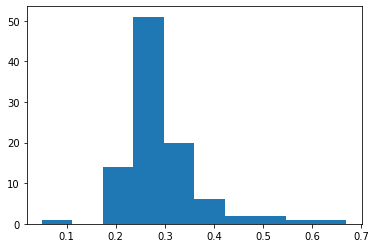

In [10]:
with loompy.connect(f_peaks) as ds:
    
    if not 'pos' in ds.ra:
        ds.ra.pos = np.ceil((ds.ra.Start.astype(int) + ds.ra.End.astype(int))/2).astype(int)

with loompy.connect(f_peaks, 'r') as ds:        
    dist_param = estimate_distance_parameter(ds, verbose=False)
    plt.hist(dist_param)
    alpha = np.mean(dist_param)
    logging.info(f'Set alpha at {alpha}')
    matrix = Compute_Coacces(ds, alpha=alpha)
    df, filtered_matrix = generate_ccans(matrix, ds.ra.ID)
    pkl.dump(filtered_matrix, open(pkl_file, 'wb'))

In [10]:
def save_connections(ds, df, outdir):
    ## Save pd dataframe
    f_CCANs = os.path.join(outdir, 'CCANs.pkl')
    all_arcs = os.path.join(outdir, 'all.arcs')
    prom_arcs = os.path.join(outdir, 'proms.arcs')
    
    ## Save connections
    df.to_pickle(f_CCANs)
    
    with open(all_arcs, 'a') as file:
        for index, row in df.iterrows():
            new_line = []
            [new_line.extend(row[p].replace(':', '-').split('-')) for p in ['peak1', 'peak2']]
            new_line.append(str(round(row['coaccess'], 2)))
            file.write('\t'.join(new_line))
            file.write('\n')
            
    ## Save promoters
#     X = np.array([x.split(' ')[0] for x in ds.ra.Annotation])
#     TSS_pos = np.where(X=='promoter-TSS')[0] ## Fix to be the closest peak to TSS
    TSS_pos = np.where(ds.ra['Distance to TSS'].astype(int)<200)[0]
    proms = ds.ra.ID[TSS_pos]
    df_prom = df[df['peak1'].isin(proms) | df['peak2'].isin(proms)]
    
    with open(prom_arcs, 'a') as file:
        for index, row in df_prom.iterrows():
            new_line = []
            [new_line.extend(row[p].replace(':', '-').split('-')) for p in ['peak1', 'peak2']]
            new_line.append(str(round(row['coaccess'], 2)))
            file.write('\t'.join(new_line))
            file.write('\n')
            

with loompy.connect(f_peaks, 'r') as ds:        
    save_connections(ds, df, cicero_dir)

NameError: name 'df' is not defined

In [94]:
def generate_Gene_Activity(ds, matrix, dist_thresh:int=2.5e5):
    logging.info(f'Starting Gene activity calculation')
    out_file = '/' + os.path.join(*ds.filename.split("/")[:-1], f'{ds.filename.split("/")[-2]}_GA.loom')
    
    ## Check if position coords already exist
    if not 'pos' in ds.ra:
        ds.ra.pos = np.ceil((ds.ra.Start.astype(int) + ds.ra.End.astype(int))/2).astype(int)
    
    ## Extract the TSS peaks
    TSS_pos = np.where(['TSS' in x for x in ds.ra['Detailed Annotation']])[0]

    ## Calculate the distances between associated peaks
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()  
    pos1 = ds.ra.pos[sources].reshape((sources.shape[0],1))
    pos2 = ds.ra.pos[targets].reshape((targets.shape[0], 1))
    dists = abs(pos1-pos2).flatten()

    ## Filter out peaks that are not associated with a TSS or too far away
    TSS_pos_s = set(TSS_pos)
    v1 = [x in TSS_pos_s for x in sources]
    v2 = [x in TSS_pos_s for x in targets]
    valids = [x ^ y for x,y in zip(v1, v2)] & (dists < dist_thresh)

    ## Generate the promoter connectivity matrix
    logging.info(f'Getting matrices')
    promoter_conn_matrix = sparse.csr_matrix((weights[valids], (sources[valids],targets[valids])), shape=matrix.shape, dtype='float')
    promoter_conn_matrix[targets[valids], sources[valids]] = weights[valids]
    promoter_conn_matrix.setdiag(1)
    promoter_conn_matrix = promoter_conn_matrix[TSS_pos,:]

    ## Distal peaks
    peaks = np.unique(np.concatenate([promoter_conn_matrix.nonzero()]))
    distal_peaks = peaks
     
    ## Weigh peaks by their connectivity to the TSS
    scaled_site_weights = np.ones(distal_peaks.shape[0])
    total_linked_site_weights = promoter_conn_matrix.tocsr()[:,distal_peaks]
    total_linked_site_weights = np.asarray(div0(1, np.sum(total_linked_site_weights, axis=1))).reshape(-1)
    total_linked_site_weights = np.diag(total_linked_site_weights)
    scaled_site_weights = total_linked_site_weights @ promoter_conn_matrix[:,distal_peaks]
    scaled_site_weights[scaled_site_weights>1] = 1

    ## Check if file already exists
    if os.path.isfile(out_file):
        os.remove(out_file)
    
    logging.info(f'Generating file')   
    
    rows = {k: ds.ra[k][TSS_pos] for k in ds.ra}
    M = len(TSS_pos)
    
    empty_mat = sparse.csr_matrix((M,ds.shape[1]), dtype=np.float32)
    logging.info(f'Create file')
    loompy.create(out_file, empty_mat, rows, ds.ca)
    with loompy.connect(out_file) as dsout:
    
        ## Transfer column_graphs
        for k in ds.col_graphs:
            dsout.col_graphs[k] = ds.col_graphs[k]
        
        ## Generate Gene Accessibility Scores
        logging.info(f'Generating gene accessibility scores')
        progress = tqdm(total = ds.shape[1])
        for (ix, selection, view) in ds.scan(axis=1):
            X = view[''][:,:][distal_peaks,:].T @ scaled_site_weights.T
            dsout[:,selection] = X.T
            progress.update(512)
        progress.close()
        
        ## Normalize
        logging.info(f'Normalizing data by coverage')
        total_peaks = dsout.ca.NPeaks
        total_activity = dsout[''].map([np.sum], axis=1)[0]

        reg = LinearRegression().fit(total_peaks[:,None], total_activity[:,None])
        fitted = reg.predict(total_peaks[:,None])
        size_factors = np.log(fitted) / np.mean(np.log(fitted))
        size_factors = size_factors.flatten()
        
        dsout["norm"] = 'float32'
        progress = tqdm(total = dsout.shape[0])
        for (_, indexes, view) in dsout.scan(axis=0, layers=[""], what=["layers"]):
            dsout["norm"][indexes.min(): indexes.max() + 1, :] = view[:, :] / size_factors
            progress.update(512)
        progress.close()
        
        ## Start pooling over the network
        logging.info(f'Start pooling over network')
        knn = dsout.col_graphs['KNN'].astype("bool")
        dsout["pooled"] = 'float32'
        progress = tqdm(total = dsout.shape[0])
        for (_, indexes, view) in dsout.scan(axis=0, layers=["norm"], what=["layers"]):
            dsout["pooled"][indexes.min(): indexes.max() + 1, :] = view["norm"][:, :] @ knn.T
            progress.update(512)
        progress.close()

['', 'CPM', 'binary', 'log2fc', 'marker_peaks', 'residuals']
250378


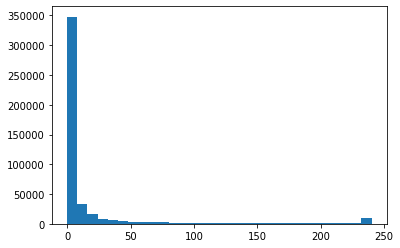

In [101]:
f_cell_peaks = '/proj/DEV_ATAC/Build_20220131/All/All_peaks.agg.loom'

with loompy.connect(f_cell_peaks, 'r') as ds:   
    print(ds.layers.keys())
    
    X  = ds['binary'].map([np.sum], axis=0)[0]
    
    plt.hist(X, bins=30)
    print(np.sum(X>0))

In [ ]:
filtered_matrix = pkl.load(open(pkl_file, 'rb'))

# f_cell_peaks = f_peaks.split('.')[0] + '.loom'
f_cell_peaks = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_peaks.loom'

with loompy.connect(f_cell_peaks, 'r') as ds:   
    generate_Gene_Activity(ds, filtered_matrix)

13:20:54 INFO     Starting Gene activity calculation
13:20:56 INFO     Getting matrices
/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
13:22:06 INFO     Generating file
13:22:26 INFO     Create file
13:23:32 INFO     Generating gene accessibility scores
 30%|███       | 16896/56174 [1:34:29<10:28:06,  1.04it/s]

In [100]:
# with loompy.connect(f_G) as dsout:        
#     ## Normalize
#     logging.info(f'Normalizing data by coverage')
#     total_peaks = dsout.ca.NPeaks
#     total_activity = dsout[''].map([np.sum], axis=1)[0]

#     reg = LinearRegression().fit(total_peaks[:,None], total_activity[:,None])
#     fitted = reg.predict(total_peaks[:,None])
#     size_factors = np.log(fitted) / np.mean(np.log(fitted))
#     size_factors = size_factors.flatten()

#     dsout["norm"] = 'float32'
#     progress = tqdm(total = dsout.shape[0])
#     for (_, indexes, view) in dsout.scan(axis=0, layers=[""], what=["layers"]):
#         dsout["norm"][indexes.min(): indexes.max() + 1, :] = view[:, :] / size_factors
#         progress.update(512)
#     progress.close()

#     ## Start pooling over the network
#     logging.info(f'Start pooling over network')
#     knn = dsout.col_graphs['KNN'].astype("bool")
#     dsout["pooled"] = 'float32'
#     progress = tqdm(total = dsout.shape[0])
#     for (_, indexes, view) in dsout.scan(axis=0, layers=["norm"], what=["layers"]):
#         dsout["pooled"][indexes.min(): indexes.max() + 1, :] = view["norm"][:, :] @ knn.T
#         progress.update(512)
#     progress.close()

20:18:50 INFO     Normalizing data by coverage
27648it [00:29, 942.41it/s]                           
20:19:30 INFO     Start pooling over network
27648it [01:02, 442.66it/s]                           


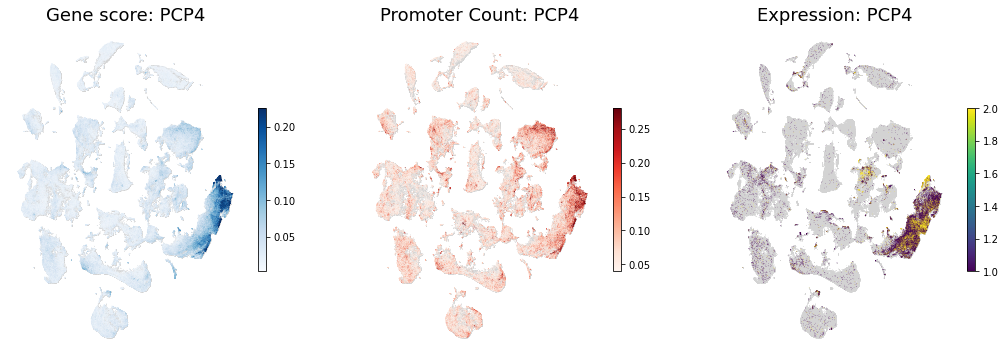

In [69]:
g = 'PCP4'
emb = 'TSNE'
s=1

# f_G = '/proj/DEV_ATAC/Build_20220131/TH/TH_GA.loom'
# f_prom = '/proj/DEV_ATAC/Build_20220131/TH/TH_prom.loom'
# f_RNA = '/proj/DEV_ATAC/Build_20220131/TH/TH_RNA_imputed.loom'

f_G = '/proj/DEV_ATAC/Build_20220131/All/All_GA.loom'
f_prom = '/proj/DEV_ATAC/Build_20220131/All/All_prom.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/All/All_RNA_imputed.loom'

fig, ax = plt.subplots(1,3, figsize=(18,6))
x = ax.flatten()
with loompy.connect(f_G) as ds:        
    sel = np.where(ds.ra['Gene Name']==g)[0][0]
    v = ds.layer['pooled'][sel,:].flatten() / 25
    x = v > 0

    ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
    im = ax[0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    ax[0].set_title(f'Gene score: {g}', fontsize=18)
    ax[0].axis('off')
    
with loompy.connect(f_prom) as ds:
    sel = np.where(ds.ra.Gene==g)[0][0]
    v = ds.layer['pooled'][sel,:].flatten() / 25
    x = v > 0

    ax[1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
    im = ax[1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Reds', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
    fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
    ax[1].set_title(f'Promoter Count: {g}', fontsize=18)
    ax[1].axis('off')

with loompy.connect(f_RNA) as ds:
    sel = np.where(ds.ra.Gene==g)[0][0]
    v = ds.layer['pooled'][sel,:].flatten()
    x = v > 0

    ax[2].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
    im = ax[2].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax=np.quantile(v, .99), cmap='viridis', marker='.', lw=0, s=s)
    fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
    ax[2].set_title(f'Expression: {g}', fontsize=18)
    ax[2].axis('off')

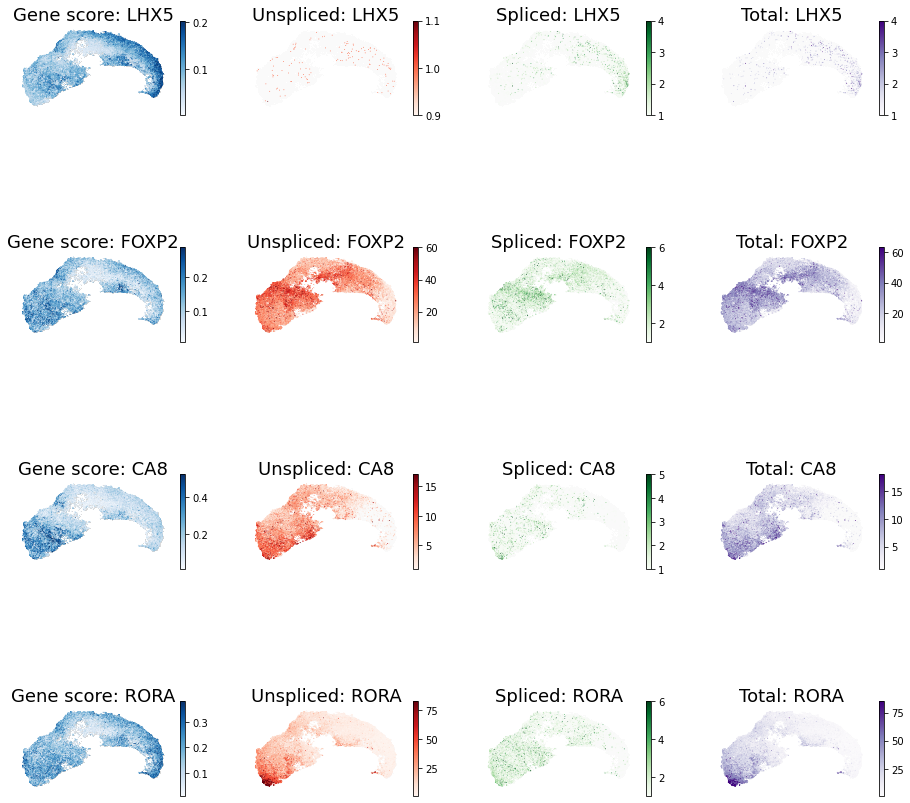

In [87]:
# genes = ['PTF1A', 'NHLH2', 'LHX5', 'POU4F1', ## Prog
#          'GAD1', 'GAD2', 'FOXP2', 'SLC32A1', ## Interneuron
#          'CALB1', 'PCP4', 'CA8', 'RORA' ## Purk
# ]

genes = ['LHX5', ## Prog
         'FOXP2', ## Interneuron
         'CA8', 'RORA' ## Purk
]
         
nrows = len(genes)

emb = 'UMAP_jaccard'
s=3

f_G = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_GA.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_RNA_imputed.loom'

fig, ax = plt.subplots(nrows,4, figsize=(16,4*nrows))

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[i,0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
        im = ax[i,0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
        fig.colorbar(im, ax=ax[i,0], orientation='vertical', shrink=.5)
        ax[i,0].set_title(f'Gene score: {g}', fontsize=18)
        ax[i,0].axis('off')
        ax[i,0].set_aspect('equal')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['unspliced_pooled'][sel,:].flatten()
        x = v > 0

        ax[i,1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='#fafafa', marker='.', lw=0, s=s)
        if np.sum(x) > 0:
            im = ax[i,1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax= np.quantile(v[x], .99), cmap='Reds', marker='.', lw=0, s=s)
            fig.colorbar(im, ax=ax[i,1], orientation='vertical', shrink=.5)
        ax[i,1].set_title(f'Unspliced: {g}', fontsize=18)
        ax[i,1].axis('off')
        ax[i,1].set_aspect('equal')

        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['spliced_pooled'][sel,:].flatten()
        x = v > 0

        ax[i,2].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='#fafafa', marker='.', lw=0, s=s)
        if np.sum(x) > 0:
            im = ax[i,2].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax= np.quantile(v[x], .99), cmap='Greens', marker='.', lw=0, s=s)
            fig.colorbar(im, ax=ax[i,2], orientation='vertical', shrink=.5)
        ax[i,2].set_title(f'Spliced: {g}', fontsize=18)
        ax[i,2].axis('off')
        ax[i,2].set_aspect('equal')

        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[i,3].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='#fafafa', marker='.', lw=0, s=s)
        if np.sum(x) > 0:
            im = ax[i,3].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax= np.quantile(v[x], .99), cmap='Purples', marker='.', lw=0, s=s)
            fig.colorbar(im, ax=ax[i,3], orientation='vertical', shrink=.5)
        ax[i,3].set_title(f'Total: {g}', fontsize=18)
        ax[i,3].axis('off')
        ax[i,3].set_aspect('equal')

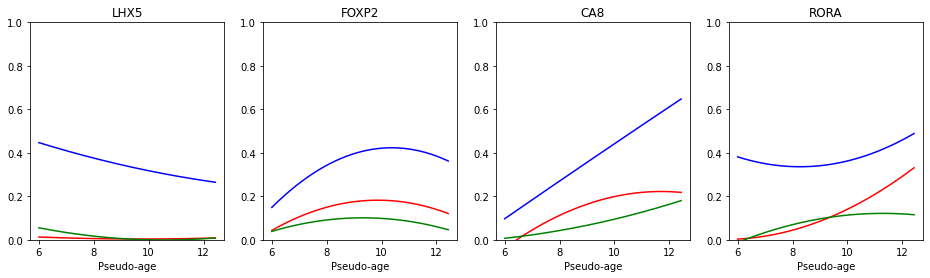

In [90]:
# genes = ['PTF1A', 'NHLH2', 'LHX5', 'POU4F1', ## Prog
#          'GAD1', 'GAD2', 'FOXP2', 'SLC32A1', ## Interneuron
#          'CALB1', 'PCP4', 'CA8', 'RORA' ## Purk
# ]

nrows = int(np.ceil(len(genes)/4))
s = 10

fig, ax = plt.subplots(nrows,4,figsize=(16,4*nrows))
ax = ax.flatten()

f_G = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_GA.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_RNA.loom'

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:   
        x = np.where(ds.ca.Chemistry=='multiome_atac')[0]
        ordered = np.argsort(ds.ca.PseudoAge[x])
        Age = np.clip(ds.ca.PseudoAge[x][ordered], 6,13)
        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        v = v[x][ordered] / np.max(v[x])
        
        z = np.polyfit(Age, v, 2)
        p = np.poly1d(z)
        
        ax[i].plot(Age, p(Age), c='blue')
#         ax[i].scatter(Age, v, marker='.', lw=0, s=1)
        ax[i].set_title(g)
        
    with loompy.connect(f_RNA) as ds:
        ordered = np.argsort(ds.ca.PseudoAge)
        Age = np.clip(ds.ca.PseudoAge[ordered], 6,13)
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['unspliced'][sel,:].flatten()
        v = v[ordered] / np.max(v)
        z = np.polyfit(Age, v, 2)
        p = np.poly1d(z)
        
        ax[i].plot(Age, p(Age), c='red')
        
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['spliced'][sel,:].flatten()
        v = v[ordered] / np.max(v)
        z = np.polyfit(Age, v, 2)
        p = np.poly1d(z)
        
        ax[i].plot(Age, p(Age), c='green')
        ax[i].set_ylim((0,1))
        
        ax[i].set_xlabel('Pseudo-age')

In [35]:
g = 'TFAP'
emb = 'TSNE'
with loompy.connect(f_G) as ds:        
    genes = ds.ra['Gene Name'][np.where([g in x for x in ds.ra['Gene Name']])[0]]
    print(genes)
    print(ds.ra['Gene Name'][ds.ra['Gene Name']==g])
    print(ds.shape)
    print(ds.layers.keys())
    x = np.flatnonzero(np.core.defchararray.find(ds.ra['Gene Name'].astype(str),g)!=-1)
    print(f"exact: {ds.ra['Gene Name'][ds.ra['Gene Name']==g]}")
    print(sorted(ds.ra['Gene Name'][x]))

['TFAP4' 'TFAP4' 'TFAP2E' 'TFAP2C' 'TFAP2C' 'TFAP2A-AS2' 'TFAP2A' 'TFAP2A'
 'TFAP2A']
[]
(27213, 56174)
['', 'norm', 'pooled']
exact: []
['TFAP2A', 'TFAP2A', 'TFAP2A', 'TFAP2A-AS2', 'TFAP2C', 'TFAP2C', 'TFAP2E', 'TFAP4', 'TFAP4']


In [59]:
with loompy.connect('/proj/DEV_ATAC/Build_20220131/Purk/Purk_peaks.loom') as ds:
    print(ds.shape)
    X = np.array([x.split(' ')[0] for x in ds.ra.Annotation])
    TSS_an = np.where(X=='promoter-TSS')[0] ## Fix to be the closest peak to TSS
    TSS_dis = np.where(abs(ds.ra['Distance to TSS'].astype(int))<250)[0]

    print(len(TSS_dis))
    valid_genes = ds.ra['Gene Name'][TSS_dis]
    print(len(np.unique(valid_genes)))

    print(len(TSS_an))
    valid_genes = ds.ra['Gene Name'][TSS_an]
    print(len(np.unique(valid_genes)))

(460591, 56174)
21304
18940
27221
22417


In [66]:
with loompy.connect('/proj/DEV_ATAC/Build_20220131/Purk/Purk_peaks.loom') as ds:
    all_genes = np.unique(ds.ra['Gene Name'])
    print(len(all_genes))
    
    proms = []
    for g in tqdm(all_genes):
        x = np.where(ds.ra['Gene Name']==g)[0]
        dist = abs(ds.ra['Distance to TSS'][x].astype(int))
        mn = np.min(dist)
        if mn < 500:
            proms.append(x[dist==mn])
        
    print(len(proms))

  0%|          | 0/46964 [00:00<?, ?it/s]

46964


100%|██████████| 46964/46964 [24:19<00:00, 32.17it/s]

22875


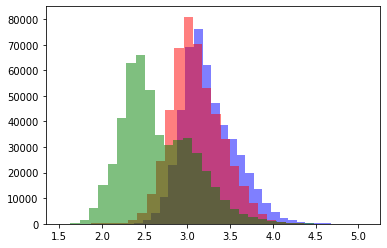

In [128]:
with loompy.connect(f_RNA) as ds:
# #     tot = ds['pooled'].map([np.sum], axis=1)[0]
#     U = ds['unspliced_pooled'].map([np.sum], axis=1)[0]
#     S = ds['spliced_pooled'].map([np.sum], axis=1)[0]
    plt.hist(np.log10(tot+1), bins =30, alpha=.5, color='blue')
    plt.hist(np.log10(U+1), bins =30, alpha=.5, color='red')
    plt.hist(np.log10(S+1), bins =30, alpha=.5, color='green')

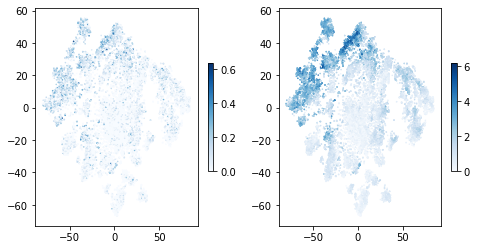

In [102]:
g = 'SLC6A5'

with loompy.connect(f_G) as ds:        
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    s = np.where(ds.ra['Gene Name']==g)[0][0]
    im1 = ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds['norm'][s,:], cmap='Blues', marker='.', s=1)
    im2 = ax[1].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds['pooled'][s,:], cmap='Blues', marker='.', s=1)
    fig.colorbar(im1, ax=ax[0], orientation='vertical', shrink=.5)
    fig.colorbar(im2, ax=ax[1], orientation='vertical', shrink=.5)

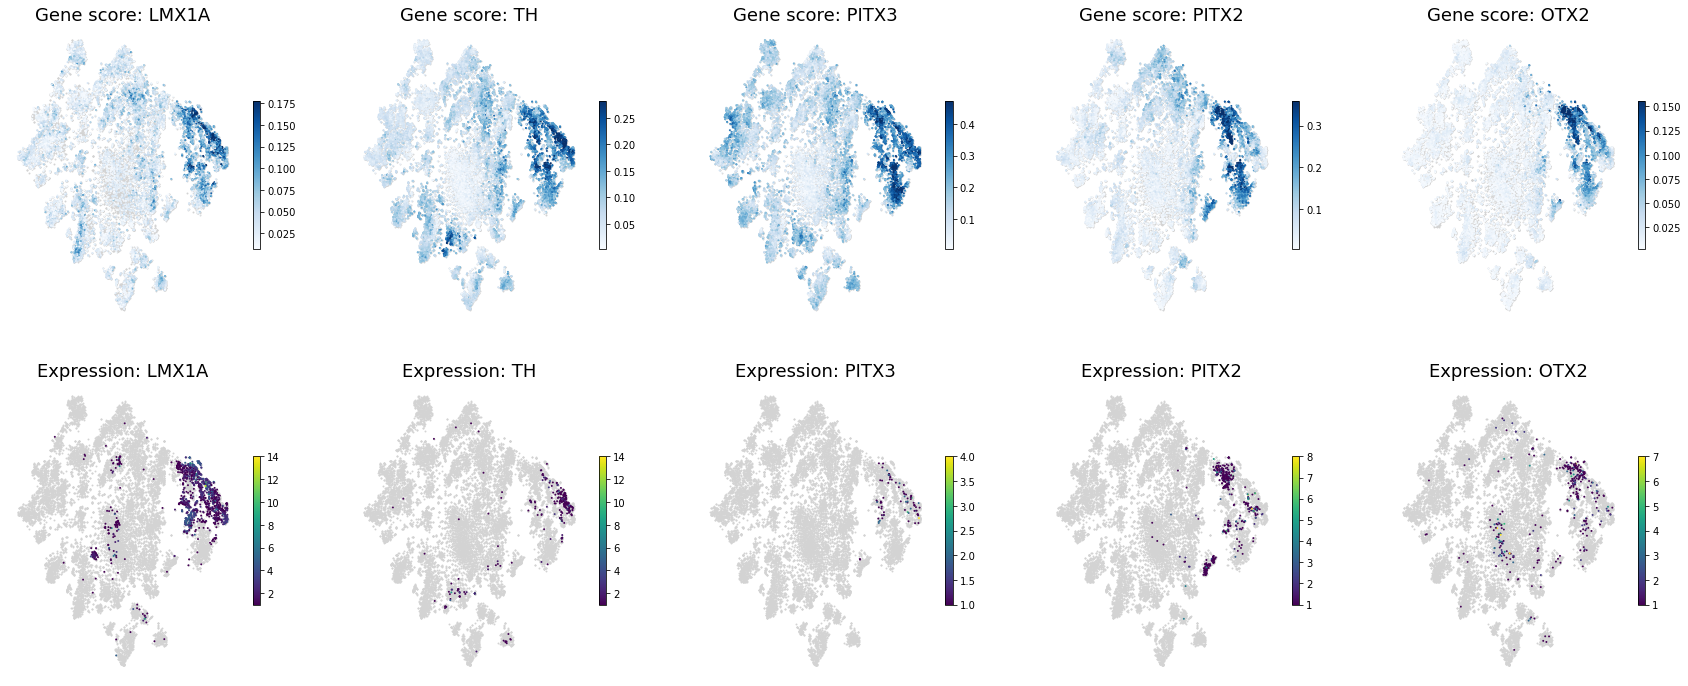

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import loompy

genes = ['LMX1A', 'TH', 'PITX3', 'PITX2', 'OTX2']
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/Build_20220131/TH/TH_GA.loom'
f_prom = '/proj/DEV_ATAC/Build_20220131/TH/TH_prom.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/TH/TH_RNA_imputed.loom'

fig, ax = plt.subplots(2, len(genes), figsize=(6*len(genes),12))
ax = ax.T

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[i,0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,0], orientation='vertical', shrink=.5)
        ax[i,0].set_title(f'Gene score: {g}', fontsize=18)
        ax[i,0].axis('off')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[i,1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,1], orientation='vertical', shrink=.5)
        ax[i,1].set_title(f'Expression: {g}', fontsize=18)
        ax[i,1].axis('off')
    
# fig.savefig('/home/camiel/misc/Gene_score_expression.png')

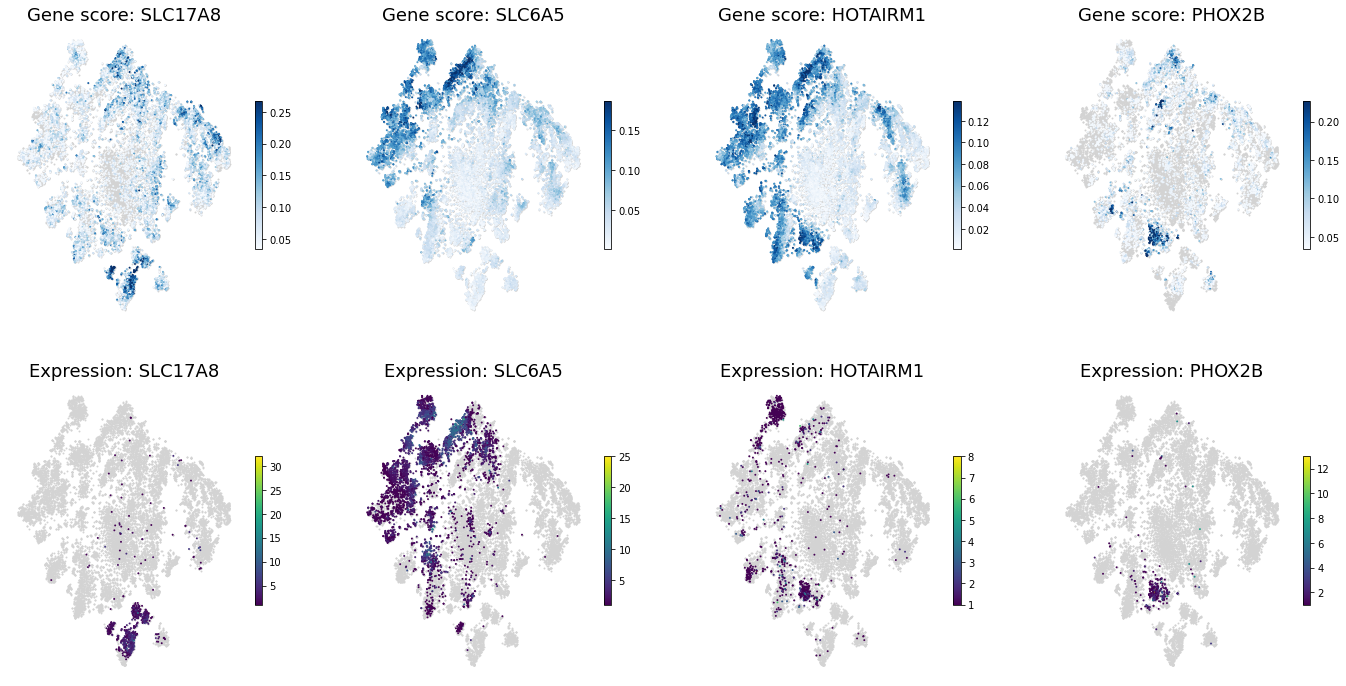

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import loompy

genes = ['SLC17A8', 'SLC6A5', 'HOTAIRM1', 'PHOX2B']
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/Build_20220131/TH/TH_GA.loom'
f_prom = '/proj/DEV_ATAC/Build_20220131/TH/TH_prom.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/TH/TH_RNA_imputed.loom'

fig, ax = plt.subplots(2, len(genes), figsize=(6*len(genes),12))
ax = ax.T

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[i,0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,0], orientation='vertical', shrink=.5)
        ax[i,0].set_title(f'Gene score: {g}', fontsize=18)
        ax[i,0].axis('off')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[i,1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,1], orientation='vertical', shrink=.5)
        ax[i,1].set_title(f'Expression: {g}', fontsize=18)
        ax[i,1].axis('off')
    
# fig.savefig('/home/camiel/misc/Gene_score_expression.png')

In [84]:
g = 'DAB1'
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/test/test_GA.loom'
with loompy.connect(f_G) as ds:        
    genes = ds.ra['Gene Name'][np.where([g in x for x in ds.ra['Gene Name']])[0]]
    print(genes)
    print(ds.ra['Gene Name'][ds.ra['Gene Name']==g])
    print(ds.shape)
    print(ds.layers.keys())
    x = np.flatnonzero(np.core.defchararray.find(ds.ra['Gene Name'].astype(str),g)!=-1)
    print(f"exact: {ds.ra['Gene Name'][ds.ra['Gene Name']==g]}")
    print(sorted(ds.ra['Gene Name'][x]))

['DAB1']
['DAB1']
(21344, 122963)
['', 'pooled']
exact: ['DAB1']
['DAB1']


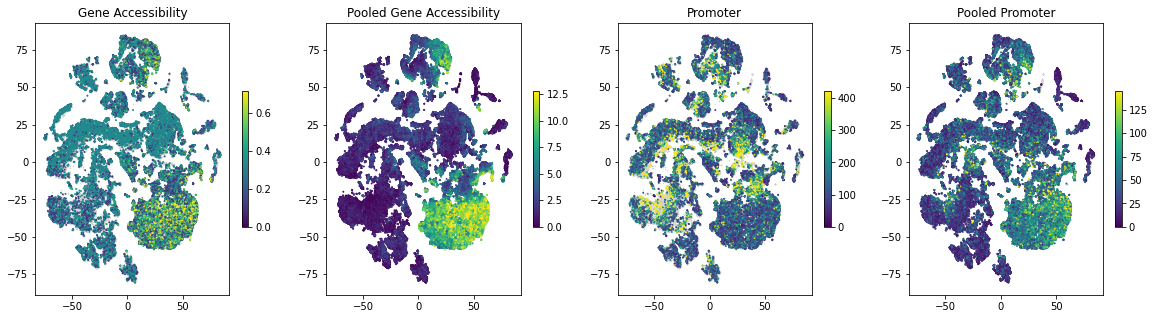

In [90]:
gene = 'TNC'
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/test/test_GA.loom'
f_prom_test = '/proj/DEV_ATAC/Build_20211016/Cerebellum/Cerebellum_prom.loom'
fig, ax = plt.subplots(1,4, figsize=(20,5))

with loompy.connect(f_G) as ds:        
    v = ds.layer[''][ds.ra['Gene Name'] == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    
    v = ds['pooled'][ds.ra['Gene Name'] == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
    ax[0].set_title('Gene Accessibility')
    ax[1].set_title('Pooled Gene Accessibility')
    
with loompy.connect(f_prom_test) as ds:
    v = ds.layer['CPM'][ds.ra.Gene == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[2].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[2].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
    ax[2].set_title('Promoter')
    
    v = ds.layer['pooled_CPM'][ds.ra.Gene == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[3].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[3].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[3], orientation='vertical', shrink=.5)
    ax[3].set_title('Pooled Promoter')

In [311]:
f_test = '/proj/DEV_ATAC/test/Cortex_peaks.loom'


with loompy.connect(f_test) as ds:   
    out_file = '/' + os.path.join(*ds.filename.split('/')[:-1], f'Cortex_GA.loom')
    
    if os.path.isfile(out_file):
        os.remove(out_file)
    
    with loompy.new(out_file) as dsout:  # Create a new, empty, loom file
        rows = {k: ds.ra[k][TSS_pos] for k in ds.ra}
        M = len(TSS_pos)
        
        pbar = tqdm(ds.shape[1])
        for (ix, selection, view) in ds.scan(axis=1):
            N = len(selection)
            empty_mat = np.zeros((M,N), dtype=np.float32)
            dsout.add_columns({'': empty_mat}, col_attrs=view.ca, row_attrs = rows)

            pbar.update(512)
        pbar.close()






0it [00:00, ?it/s]




512it [00:13, 36.67it/s]




1024it [00:24, 42.74it/s]




1536it [00:32, 49.58it/s]




2048it [00:41, 53.30it/s]




2560it [00:49, 55.66it/s]




3072it [00:58, 57.38it/s]




3584it [01:06, 58.32it/s]




4096it [01:15, 58.74it/s]




4608it [01:24, 58.77it/s]




5120it [01:32, 59.23it/s]




5632it [01:41, 59.51it/s]




6144it [01:49, 58.98it/s]




6656it [01:58, 58.79it/s]




7168it [02:07, 58.72it/s]




7680it [02:16, 59.00it/s]




8192it [02:24, 59.19it/s]




8704it [02:33, 59.23it/s]




9216it [02:42, 58.70it/s]




9728it [02:51, 56.66it/s]


In [211]:
f_test = '/proj/DEV_ATAC/test/Cortex_peaks.loom'
dist_thresh = 2.5e5

with loompy.connect(f_test) as ds:        
    
    print(ds.shape)
    
    if not 'pos' in ds.ra:
        ds.ra.pos = np.ceil((ds.ra.Start.astype(int) + ds.ra.End.astype(int))/2).astype(int)
    
    X = np.array([x.split(' ')[0] for x in ds.ra.Annotation])
    TSS_pos = np.where(X=='promoter-TSS')[0]

    sources, targets = filtered_matrix.nonzero()
    weights = filtered_matrix.data.flatten()  
    pos1 = ds.ra.pos[sources].reshape((sources.shape[0],1))
    pos2 = ds.ra.pos[targets].reshape((targets.shape[0], 1))
    dists = abs(pos1-pos2).flatten()

    TSS_pos_s = set(TSS_pos)
    v1 = [x in TSS_pos_s for x in sources]
    v2 = [x in TSS_pos_s for x in targets]
    valids = [x ^ y for x,y in zip(v1, v2)] & (dists < dist_thresh)

    promoter_conn_matrix = sparse.csr_matrix((weights[valids], (sources[valids],targets[valids])), shape=matrix.shape, dtype='float')
    promoter_conn_matrix[targets[valids], sources[valids]] = weights[valids]
    promoter_conn_matrix.setdiag(1)
    promoter_conn_matrix = promoter_conn_matrix[TSS_pos,:]
#     dist_matrix = sparse.csr_matrix((dists[valids], (sources[valids],targets[valids])), shape=matrix.shape, dtype='float')

    ## Distal peaks
    peaks = np.unique(np.concatenate([promoter_conn_matrix.nonzero()]))
    distal_peaks = peaks
#     distal_peaks = np.array([x for x in peaks if x not in TSS_pos_s])
    
    promoter_activity = ds['Binary'][:,:][TSS_pos,:]
    distal_matrix = ds['Binary'][:,:][distal_peaks,:]
    
    

(586042, 9549)


/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [285]:
promoter_conn_matrix.shape

(23629, 586042)

In [212]:
scaled_site_weights = np.ones(distal_peaks.shape[0])
total_linked_site_weights = promoter_conn_matrix.tocsr()[:,distal_peaks]
total_linked_site_weights = np.asarray(div0(1, np.sum(total_linked_site_weights, axis=1))).reshape(-1)
total_linked_site_weights = np.diag(total_linked_site_weights)

scaled_site_weights = total_linked_site_weights @ promoter_conn_matrix[:,distal_peaks]
scaled_site_weights[scaled_site_weights>1] = 1

print(total_linked_site_weights.shape, promoter_conn_matrix.shape, scaled_site_weights.shape)

(23629, 23629) (23629, 586042) (23629, 68773)


(array([19145.,  9858.,  5019.,  1218.,  1010.,  1239.,   838.,  2276.,
            0., 15813.]),
 array([0.0119999 , 0.11079991, 0.20959992, 0.30839993, 0.40719994,
        0.50599995, 0.60479996, 0.70359997, 0.80239998, 0.90119999,
        1.        ]),
 <BarContainer object of 10 artists>)

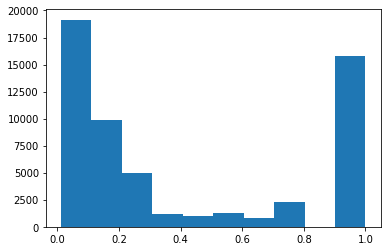

In [213]:
x = scaled_site_weights.flatten()
plt.hist(x[x>0])

In [231]:
X = np.zeros(())
with loompy.connect(f_test) as ds:        

    X = np.zeros((scaled_site_weights.shape[0],ds.shape[1])).T
    print(X.shape)
    
    progress = tqdm(total = ds.shape[1])
    for (ix, selection, view) in ds.scan(axis=1):
        X[selection,:] = view['Binary'][:,:][distal_peaks,:].T @ scaled_site_weights.T
        progress.update(512)
    progress.close()

    promoter_activity_scores = X.T
# distal_activity = np.concatenate(X)
        
# distal_activity = distal_matrix.T @ scaled_site_weights.T

# # promoter_activity_scores = distal_activity.T + promoter_activity
# promoter_activity_scores = distal_activity.T





  0%|          | 0/9549 [00:00<?, ?it/s]

(9549, 23629)






  5%|▌         | 512/9549 [01:02<18:22,  8.19it/s]



 11%|█         | 1024/9549 [01:49<14:44,  9.64it/s]



 16%|█▌        | 1536/9549 [02:35<13:01, 10.26it/s]



 21%|██▏       | 2048/9549 [03:21<11:48, 10.59it/s]



 27%|██▋       | 2560/9549 [04:07<10:48, 10.77it/s]



 32%|███▏      | 3072/9549 [04:53<09:54, 10.90it/s]



 38%|███▊      | 3584/9549 [05:38<09:01, 11.02it/s]



 43%|████▎     | 4096/9549 [06:24<08:13, 11.05it/s]



 48%|████▊     | 4608/9549 [07:11<07:28, 11.03it/s]



 54%|█████▎    | 5120/9549 [07:57<06:41, 11.04it/s]



 59%|█████▉    | 5632/9549 [08:43<05:54, 11.05it/s]



 64%|██████▍   | 6144/9549 [09:30<05:08, 11.04it/s]



 70%|██████▉   | 6656/9549 [10:16<04:22, 11.04it/s]



 75%|███████▌  | 7168/9549 [11:02<03:35, 11.07it/s]



 80%|████████  | 7680/9549 [11:49<02:48, 11.09it/s]



 86%|████████▌ | 8192/9549 [12:35<02:02, 11.04it/s]



 91%|█████████ | 8704/9549 [13:20<01:16, 11.09it/s]



 97%|█████████▋| 9216/9549 [14:06<00:29, 11.13it/s]



9728it 

(array([1.7945231e+08, 3.0599570e+06, 3.4402060e+06, 1.3233190e+06,
        1.1119060e+06, 1.3475770e+06, 1.2572130e+06, 3.3582550e+06,
        6.0867700e+05, 3.0595416e+07]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

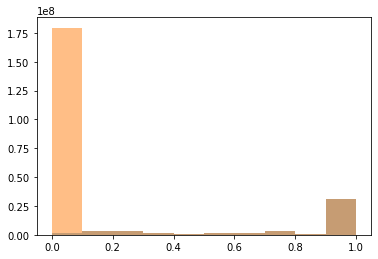

In [240]:
promoter_activity_scores = X
x = promoter_activity_scores.flatten()

plt.figure()
plt.hist(x[x>0], alpha=.5, range=(0,1))
plt.hist(x, alpha=.5, range=(0,1))

In [241]:
promoter_activity_scores.shape

(23629, 9549)

(array([1.826e+03, 7.050e+02, 1.870e+02, 8.500e+01, 5.100e+01, 1.100e+01,
        4.000e+00, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([  32.3656 ,  191.73067,  351.09573,  510.4608 ,  669.82587,
         829.1909 ,  988.55597, 1147.921  , 1307.2861 , 1466.6511 ,
        1626.0162 ], dtype=float32),
 <BarContainer object of 10 artists>)

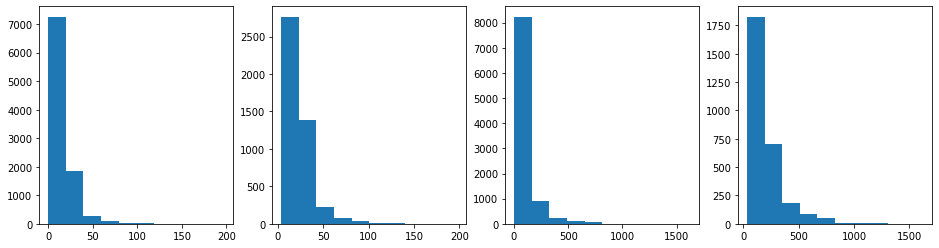

In [242]:
g = 'FABP7'

with loompy.connect(f_test) as ds:        
    genes = ds.ra['Gene Name'][TSS_pos]
    
    x = (promoter_activity_scores[genes == g, :] / ds.ca.NPeaks) * 1e6
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].hist(x.flatten())
ax[1].hist(x[x>0])

with loompy.connect(f_prom_test) as ds:
    x = ds.layer['CPM'][ds.ra.Gene == gene,:].flatten()
ax[2].hist(x)
ax[3].hist(x[x>0])

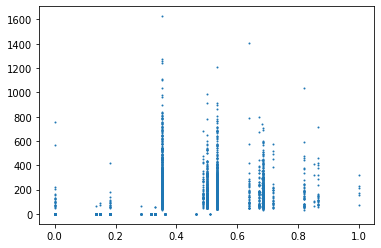

In [284]:
gene = 'FABP7'
emb = 'TSNE'
f_prom_test = '/proj/DEV_ATAC/Build_20210312/Cortex/Cortex_prom.loom'

with loompy.connect(f_test) as ds:        
    genes = ds.ra['Gene Name'][TSS_pos]
    v1 = promoter_activity_scores[genes == gene, :].flatten()
        
with loompy.connect(f_prom_test) as ds:
    v2 = ds.layer['CPM'][ds.ra.Gene == gene,:].flatten()
    
plt.scatter(v1,v2, s=1)

(array([ 339624.,  727696.,  709581.,  626336.,  644787.,  581746.,
         193460.,   82532.,    8412., 1978715.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

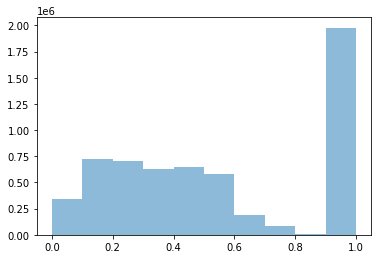

In [138]:
x1 = distal_activity.flatten()
x2 = promoter_activity.flatten()
plt.hist(x1[x1>0], alpha=.5, range=(0,1))
plt.hist(x2, alpha=.5, range=(0,1))

In [ ]:
promoter_gene_mat = sparse.csr_matrix((dists[valids], (sources[valids],targets[valids])), shape=matrix.shape, dtype='float')

In [ ]:
def build_composite_gene_activity_matrix():
    
    

In [57]:
# with loompy.connect(f_peaks, 'r') as ds:        
#     X = np.array([x.split(' ')[0] for x in ds.ra.Annotation])
#     TSS_IDs = ds.ra.ID[np.where(X=='promoter-TSS')[0]]
#     Genes = ds.ra['Gene Name'][np.where(X=='promoter-TSS')[0]]
#     G_dict = {k:v for k,v in zip(TSS_IDs, Genes)}
    
# TSS = set(TSS_IDs)
# Genes = np.repeat("", df.shape[0])
# idx = [index for index, row in df.iterrows() if row.peak1 in TSS]
# X = [G_dict[x] for x in df.peak1 if x in TSS]

# Genes = {k:v for k, v in zip(idx,X)}

In [275]:
# df[df.coaccess == max(df.coaccess)]
counts = Counter(df.CCAN)
most_peaks = np.max([i for i in counts.values()])
[k for k,v in counts.items() if v == most_peaks]

[5355]

In [63]:
f_CCANs = '/proj/DEV_ATAC/test/CCANs.pkl'
f_matrix = '/proj/DEV_ATAC/test/cicero_matrix.pkl'
df = pkl.load(open(f_CCANs, 'rb'))
matrix = pkl.load(open(f_matrix, 'rb'))

16:42:06 INFO     Region: chr10:9269673-11250361


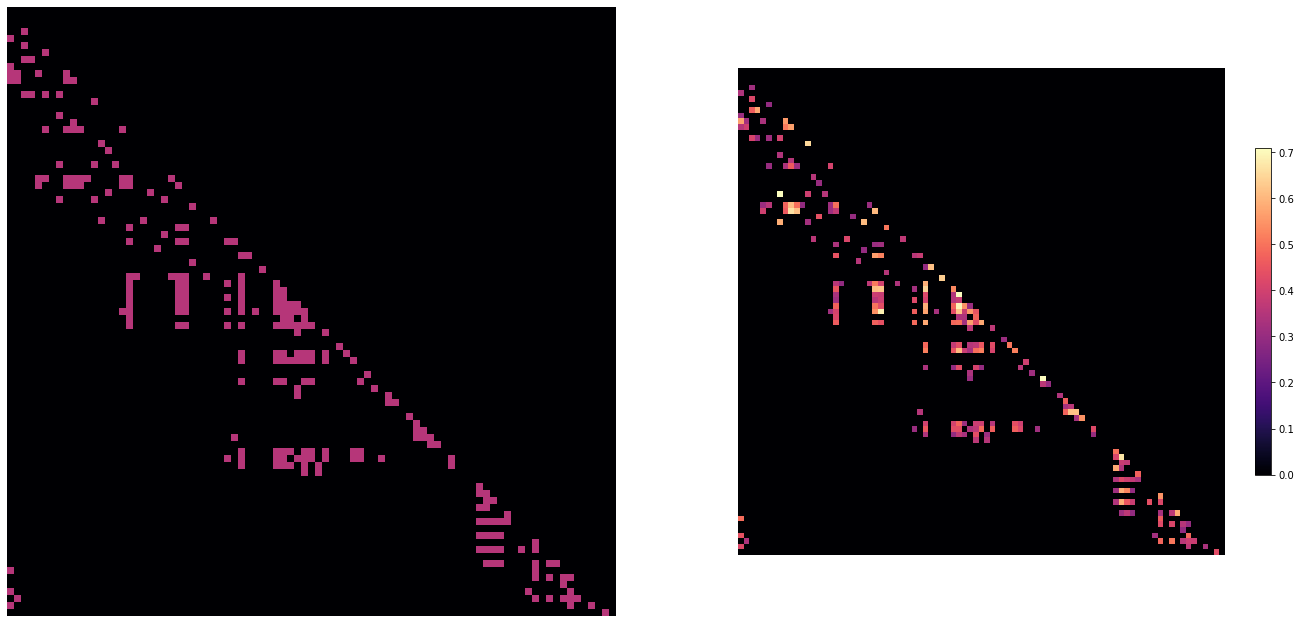

In [72]:
x = 3
whole_region = False

peaks = np.unique(np.concatenate([df.peak1[df.CCAN==x], df.peak2[df.CCAN==x]]))

with loompy.connect(f_peaks, 'r') as ds:
    if whole_region == True:
        v = np.where([x in peaks for x in ds.ra.ID])[0]
        k = range(min(v),max(v)+1)
        logging.info(f'Peaks in CCAN: {len(v)}, peaks in region: {len(k)}')
    else:
        k = np.where([x in peaks for x in ds.ra.ID])[0]

    chrom = ds.ra.Chr[v[0]]
    start = np.min(ds.ra.Start[v].astype(int)) - 100
    end = np.max(ds.ra.End[v].astype(int)) + 100
        
logging.info(f'Region: {chrom}:{start}-{end}')
        
X = matrix[k,:][:,k]
r, c = X.nonzero()
to_plot = np.zeros(X.shape)
to_plot[r,c] = X.data
b_plot = to_plot > 0.25

fig, ax = plt.subplots(1,2, figsize=(24,12))
im = ax[0].imshow(b_plot, vmin = 0, vmax=2, cmap = 'magma')  
ax[0].axis('off')

q = np.quantile(X.data, 0.99)
im = ax[1].imshow(to_plot, vmin=0, vmax=q, cmap='magma')
ax[1].axis('off')
fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)

(array([1.97028e+05, 1.19858e+05, 7.58310e+04, 4.95150e+04, 3.26040e+04,
        2.09320e+04, 9.15900e+03, 1.53800e+03, 4.98000e+02, 1.32000e+02]),
 array([0.29000194, 0.35927658, 0.42855121, 0.49782585, 0.56710048,
        0.63637512, 0.70564975, 0.77492439, 0.84419902, 0.91347366,
        0.98274829]),
 <BarContainer object of 10 artists>)

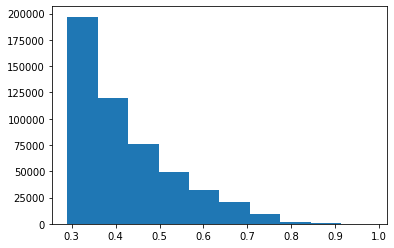

In [75]:
plt.hist(df.coaccess)

13:06:26 INFO     Peaks in CCAN: 69, peaks in region: 212


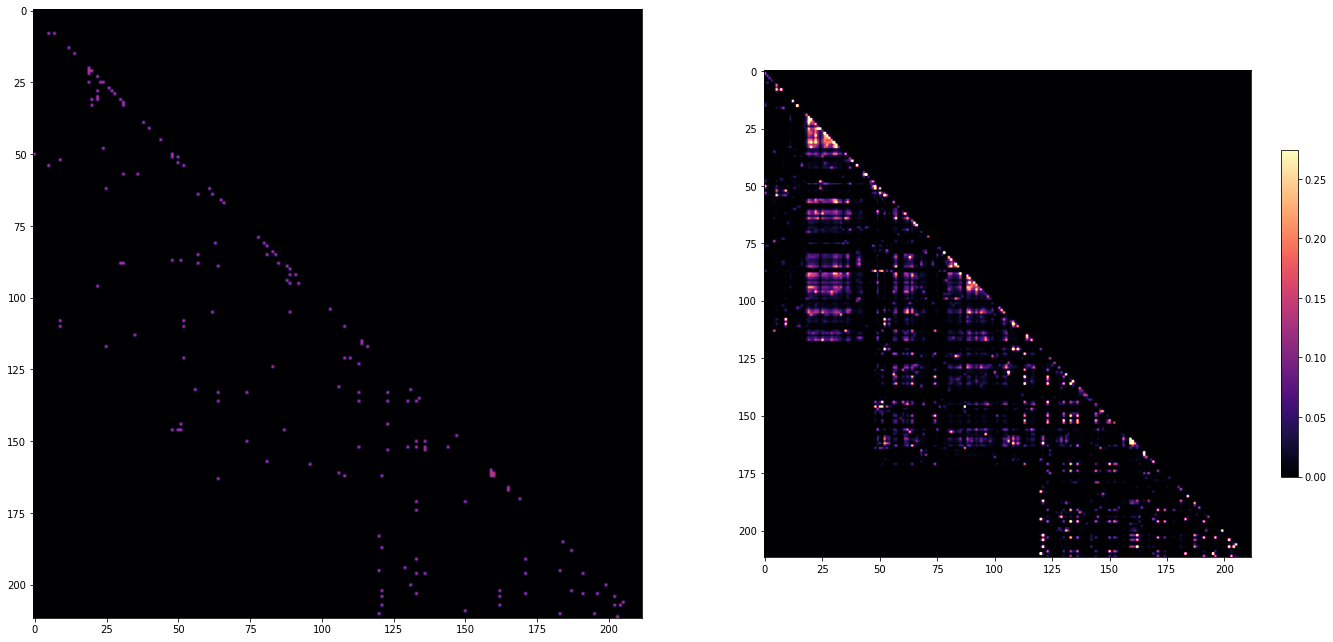

In [426]:
x = 0
whole_region = True

peaks = np.unique(np.concatenate([df.peak1[df.CCAN==x], df.peak2[df.CCAN==x]]))

with loompy.connect(f_peaks, 'r') as ds:
    if whole_region == True:
        v = np.where([x in peaks for x in ds.ra.ID])[0]
        k = range(min(v),max(v)+1)
        logging.info(f'Peaks in CCAN: {len(v)}, peaks in region: {len(k)}')
    else:
        k = np.where([x in peaks for x in ds.ra.ID])[0]
    
X = matrix[k,:][:,k]
r, c = X.nonzero()
to_plot = np.zeros(X.shape)
to_plot[r,c] = X.data
b_plot = to_plot > 0.25

fig, ax = plt.subplots(1,2, figsize=(24,12))
im = ax[0].imshow(b_plot, vmin = 0, vmax=2, cmap = 'magma')  

q = np.quantile(X.data, 0.99)
im = ax[1].imshow(to_plot, vmin=0, vmax=q, cmap='magma')
fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)

In [417]:
from matplotlib.colors import to_hex
from pygenometracks import tracks

def plot_CCAN(ds, matrix, df, out_file, CCAN=None, padding = 10000, whole_region:bool=True):
    '''
    '''

    peaks = np.unique(np.concatenate([df.peak1[df.CCAN==CCAN], df.peak2[df.CCAN==CCAN]]))
    peak_ref = '/proj/DEV_ATAC/Build_20210203/All/peaks/Compounded_peaks.bed'
    bed_ref = '/datb/sl/camiel/scATAC/ref/gencode.basic.annotation.sort.bed12'
    temp_file = '/home/camiel/misc/temp.arcs'
    
    if os.path.isfile(temp_file):
        os.remove(temp_file)

    if CCAN != None:
        if whole_region:
            v = np.where([x in peaks for x in ds.ra.ID])[0]
            k = range(min(v),max(v)+1)
            logging.info(f'Peaks in CCAN: {len(v)}, peaks in region: {len(k)}')
        else:
            k = np.where([x in peaks for x in ds.ra.ID])[0]

        df = df[df.CCAN==x]

    with open(temp_file, 'a') as file:
        for index, row in df.iterrows():
            new_line = []
            [new_line.extend(row[p].replace(':', '-').split('-')) for p in ['peak1', 'peak2']]
            new_line.append(str(round(row['coaccess'], 2)))
            file.write('\t'.join(new_line))
            file.write('\n')

#     fig, ax = plt.subplots(2, 1, figsize = (24,8))
            
#     ## Set region
#     start = np.min([int(p.split(':')[1].split('-')[0]) for p in peaks])
#     end = np.max([int(p.split(':')[1].split('-')[1]) for p in peaks])
#     chrom = peaks[0].split(':')[0]

#     ## Add padding
#     start = start - padding
#     end = end + padding
            
#     logging.info(f'Plotting region: {chrom}:{start}-{end} of size: {end-start}')
        
#     ## Plot peak reference
#     properties_dict = {'file': peak_ref, 'title': 'Gencode', 'color': '#abd9e9', 'color_utr': '#f46d43', 'height_utr': .8, 'fontsize': 8, 
#                        'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'flybase', 'labels': 'true',
#                        'dpi': 144}
#     peaks = tracks.BedTrack(properties_dict)
#     ax[1].set_xlim(start, end)
#     ax[1].axis("off")
#     peaks.plot(ax[1], chrom, start, end)
#     ax[1].plot
    
#     ## properties links
#     properties_dict = {'file': temp_file, 'title' : 'Coaccessibility', 'line_style' : 'dashed', 'height' : 2}
#     links = tracks.LinksTrack(properties_dict)
#     links.plot(ax[0], chrom, start, end)

#     ## Plot gene reference
#     ## Plot gene reference
#     properties_dict = {'file': bed_ref, 'title': 'Gencode', 'color': '#abd9e9', 'color_utr': '#f46d43', 'height_utr': .8, 'fontsize': 8, 
#                        'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'flybase', 'labels': 'true',
#                        'dpi': 144}
#     gene = tracks.BedTrack(properties_dict)
#     ax[-1].set_xlim(start, end)
#     ax[-1].axis("off")
#     gene.plot(ax[-1], chrom, start, end)
        
#     plt.savefig(out_file)

ValueError: zero-size array to reduction operation minimum which has no identity

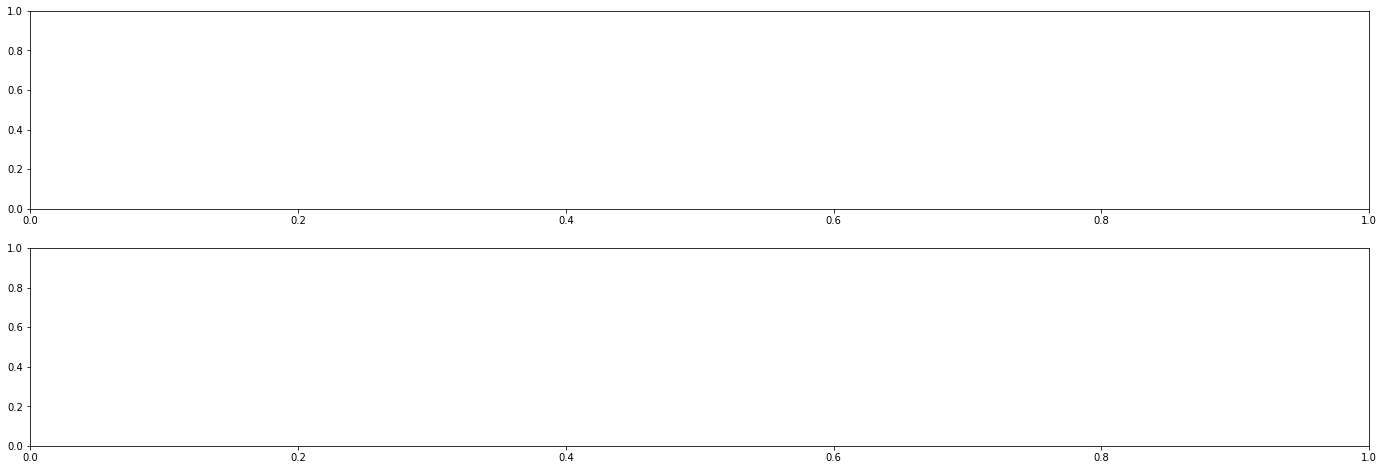

In [418]:
with loompy.connect(f_peaks) as ds:
    plot_CCAN(ds, matrix, df, out_file='/home/camiel/misc/line_plot.pdf')

In [336]:
import tempfile

x = 0
X = df[df.CCAN==x]

with tempfile.NamedTemporaryFile() as file:
    print(file)
    for index, row in X.iterrows():
        new_line = []
        [new_line.extend(row[p].replace(':', '-').split('-')) for p in ['peak1', 'peak2']]
        new_line.append(str(row['coaccess']))
        file.write(bytes('\n', encoding = 'utf-8'))
        file.write(bytes('\t'.join(new_line), encoding = 'utf-8'))

In [121]:
print(len(comp_list))
print(len(sizes))
print(sources.shape)

408898
229682
(359245,)


In [122]:
idx = set(G.vs.indices)
print(np.sum([x in idx for x in sources]))

df = pd.DataFrame({'sources':sources, 'targets':targets, 'CCAN':np.array(comp_list)[sources], 'coaccess':weights})
df = df[df['CCAN'].isin(valids)]
df.head()

359245


,sources,targets,CCAN,coaccess
1,35,32,31,0.320666
2,35,34,31,0.438295
5,47,46,26,0.337924
6,48,46,26,0.322366
7,48,47,26,0.516531


In [116]:
# Counter(df.CCAN)

In [112]:
print(valids)
print(np.array(comp_membership.sizes())[valids])

[    26     31     54 ... 229659 229673 229681]
[69 26  3 ...  3  6 11]


In [125]:
matrix[35,34]

0.43829526543823527

In [252]:
with loompy.connect(f_peaks, 'r') as ds:        
    peaks1 = ds.ra.ID[sources]
    peaks2 = ds.ra.ID[targets]

In [251]:
peaks

array(['chr1:180775-181166', 'chr1:181343-181783', 'chr1:817035-817487',
       ..., 'chrY:56847419-56847595', 'chrY:56847419-56847595',
       'chrY:56850784-56851101'], dtype=object)

In [154]:
np.array(targets)[x.indices].ravel().shape

(687496,)

(array([1.0000e+00, 3.0000e+00, 8.0000e+00, 2.4000e+01, 6.0000e+01,
        9.6000e+01, 2.0700e+02, 5.0400e+02, 1.4050e+03, 7.5160e+03,
        7.2902e+04, 8.5210e+03, 3.5240e+03, 1.9170e+03, 1.0900e+03,
        7.3300e+02, 4.6600e+02, 3.5200e+02, 2.2800e+02, 1.4500e+02,
        1.0400e+02, 6.1000e+01, 3.8000e+01, 2.4000e+01, 2.7000e+01,
        1.7000e+01, 7.0000e+00, 8.0000e+00, 5.0000e+00, 7.0000e+00]),
 array([-0.3848666 , -0.34704338, -0.30922015, -0.27139693, -0.23357371,
        -0.19575049, -0.15792726, -0.12010404, -0.08228082, -0.04445759,
        -0.00663437,  0.03118885,  0.06901208,  0.1068353 ,  0.14465852,
         0.18248174,  0.22030497,  0.25812819,  0.29595141,  0.33377464,
         0.37159786,  0.40942108,  0.4472443 ,  0.48506753,  0.52289075,
         0.56071397,  0.5985372 ,  0.63636042,  0.67418364,  0.71200687,
         0.74983009]),
 <BarContainer object of 30 artists>)

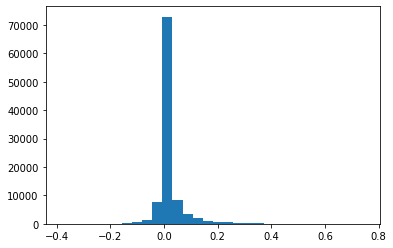

In [237]:
plt.hist(vals[:100000], bins=30)

In [235]:
lim = 0.25
print(vals.shape)
print(np.sum(vals>lim)/vals.shape[0])
print(np.sum(vals>lim))

(24179174,)
0.014341929132897592
346776


In [113]:
window_size = 500000

x_min = 500000
win = np.array([x_min, x_min + window_size])

with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
    mat = ds_peaks['CPM'][X,:]
    pos = ds_peaks.ra.pos[X]
    dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    logging.info(mat.shape)

12:49:22 INFO     (50, 155)


14:42:55 INFO     (50, 155)
14:42:55 INFO     Range of covariance: -0.118189800328196 - 1.295319661719359


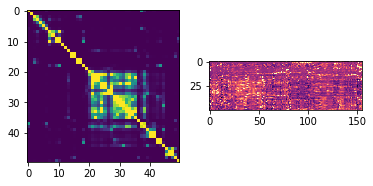

In [108]:
window_size = 500000
s = 0.75

x_min = 500000
x_max = x_min + window_size

with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
    mat = ds_peaks['CPM'][X,:]
    pos = ds_peaks.ra.pos[X]
    dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    logging.info(mat.shape)

rho = rho_matrix(dist, alpha, s, xmin=1000)

mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
mat /= mat.std(axis=1).reshape(mat.shape[0],1)
cov = np.cov(mat)

model = QuicGraphLasso(lam=rho, init_method='cov')
GLasso = model.fit(mat.T);

fig, ax = plt.subplots(1,2)
ax[0].imshow(GLasso.covariance_,vmin = 0, vmax = .25)
ax[1].imshow(mat, vmin=-3, vmax=3, cmap = 'magma')
logging.info(f'Range of covariance: {np.min(GLasso.covariance_)} - {np.max(GLasso.covariance_)}')

13:22:22 INFO     (110, 155)
/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLasso is deprecated; The class QuicGraphLasso is deprecated Use class QuicGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)
13:22:24 INFO     Range of covariance: -701.1341921260484 - 4673.757489410023


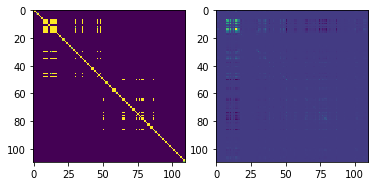

In [162]:
s = 0.75
dist_param = .1
window_size = 500000

x_min = 2500000
x_max = x_min + window_size

with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
    mat = ds_peaks['CPM'][X,:]
    pos = ds_peaks.ra.pos[X]
    dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    logging.info(mat.shape)

rho = rho_matrix(dist, dist_param, s, xmin=1000)
# mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
# mat /= mat.std(axis=1).reshape(mat.shape[0],1)
cov = np.cov(mat)
np.fill_diagonal(cov,cov.diagonal()+1e-4)

model = QuicGraphLasso(lam=rho, init_method='cov')
GLasso = model.fit(cov);

fig, ax = plt.subplots(1,2)
ax[0].imshow(GLasso.covariance_,vmin = 0, vmax = .25)
ax[1].imshow(cov)
logging.info(f'Range of covariance: {np.min(GLasso.covariance_)} - {np.max(GLasso.covariance_)}')

(array([2.424e+03, 5.500e+01, 1.200e+01, 4.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ -4.08830035,  20.62733605,  45.34297246,  70.05860886,
         94.77424527, 119.48988168, 144.20551808, 168.92115449,
        193.63679089, 218.3524273 , 243.06806371]),
 <a list of 10 Patch objects>)

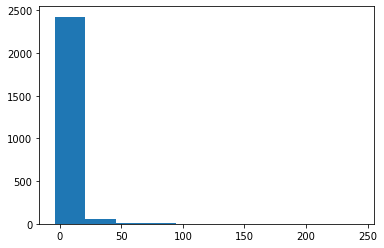

In [126]:
plt.hist(GLasso.covariance_.flatten())

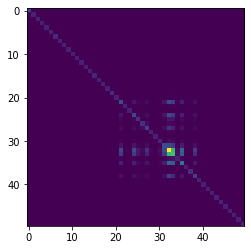

In [119]:
thresh = .25
X = GLasso.covariance_.copy()
X[X<thresh] = 0
plt.imshow(X)

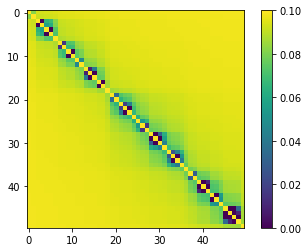

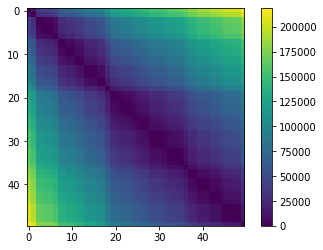

In [120]:
plt.imshow(rho)
plt.colorbar()

plt.figure()
plt.imshow(dist)
plt.colorbar()

(array([ 208., 2058.,  132.,   36.,    8.,    8.,    0.,    0.,    0.,
          50.]),
 array([-0.14663896, -0.00616335,  0.13431226,  0.27478786,  0.41526347,
         0.55573908,  0.69621469,  0.83669029,  0.9771659 ,  1.11764151,
         1.25811711]),
 <a list of 10 Patch objects>)

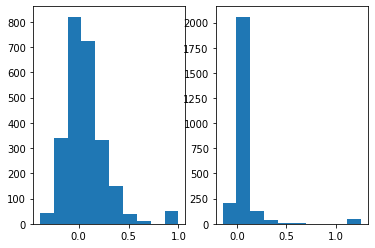

In [58]:
fig, ax = plt.subplots(1,2)
ax[0].hist(cov.flatten())
ax[1].hist(GLasso.covariance_.flatten())

In [452]:
import warnings

window_size = 500000

Co_acc = []
positions = []

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    with loompy.connect(ch1_peaks) as ds_peaks:
        chromosome_size = int(np.max(ds_peaks.ra.pos))
        for x_min in range(0, chromosome_size, int(window_size/2)):
            x_max = min(x_min + window_size, chromosome_size)
            X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)

            if np.sum(X) > 1:
                try:
                    mat = ds_peaks['CPM'][X,:]
                    pos = ds_peaks.ra.pos[X]
                    dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))

#                     mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
#                     mat /= mat.std(axis=1).reshape(mat.shape[0],1)

                    cov = corr2_coeff(mat, mat)
                    np.fill_diagonal(cov,1e-4)
                    GLasso = GraphicalLasso().fit(cov);

                    positions.append(X)
                    Co_acc.append(GLasso.covariance_)
                    
                except Exception as e:
                    logging.info(f'Error in sample: {x_min}:{x_max} with {np.sum(X)} features')
                    logging.info(e)

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -4.965e-04
  % (max_iter, d_gap), ConvergenceWarning)
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.234e-03
  % (max_iter, d_gap), ConvergenceWarning)
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.284671797665421e-05, tolerance: 1.1188391967819176e-05
  check_random_state(None), False)
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

In [501]:
with loompy.connect(ch1_peaks) as ds_peaks:
    X = sparse.dok_matrix((ds_peaks.shape[0], ds_peaks.shape[0]), dtype=np.float16)
    
    for mat, pos in zip(Co_acc, positions):
        loc = np.where(pos)[0]
        s = np.min(loc)
        end = np.max(loc)+1
        X[s:end,s:end] = mat[:,:]

(array([2.400000e+01, 3.028313e+06, 8.000000e+00, 2.500000e+01,
        9.000000e+00, 0.000000e+00, 0.000000e+00, 7.000000e+00,
        0.000000e+00, 2.700000e+01]),
 array([-1.135 , -0.4468,  0.2415,  0.9297,  1.617 ,  2.305 ,  2.994 ,
         3.682 ,  4.37  ,  5.06  ,  5.746 ], dtype=float16),
 <BarContainer object of 10 artists>)

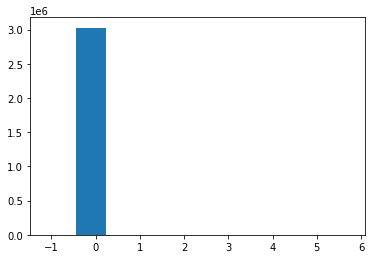

In [503]:
plt.hist(X.values())

(array([ 56.,  27.,  76., 113.,  75.,  64.,  54.,  23.,   7.,   3.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <BarContainer object of 10 artists>)

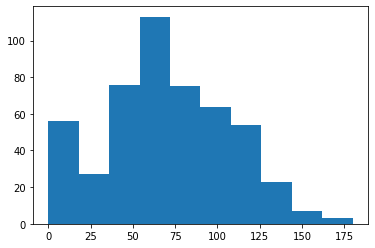

In [289]:
window_size = 500000
with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    for x_min in range(0, chromosome_size, int(window_size/2)):
        x_max = min(x_min + window_size, chromosome_size)
        X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
        mat = ds_peaks['CPM'][X,:]
        pos = ds_peaks.ra.pos[X]
        dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    
plt.hist(N)